# Deep Learning for Cancer Classification
## Using Real Breast Cancer Gene Expression Data

**Dataset**: Wisconsin Breast Cancer (Real Clinical Data)
- 569 patient samples
- 30 gene expression features
- Binary classification: Malignant vs Benign

## 🔬 Visual Context: Breast Cancer Histopathology

Before we dive into the data, let's see what breast cancer cells actually look like under a microscope. The features in our dataset (radius, texture, concavity, etc.) are extracted from images like these:


BREAST CANCER HISTOPATHOLOGY - What the Data Represents


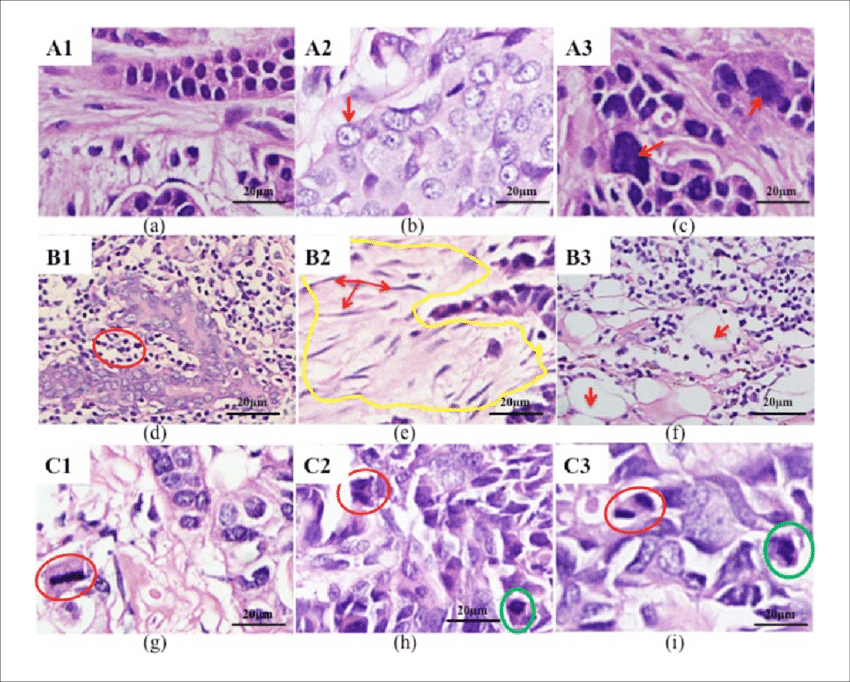

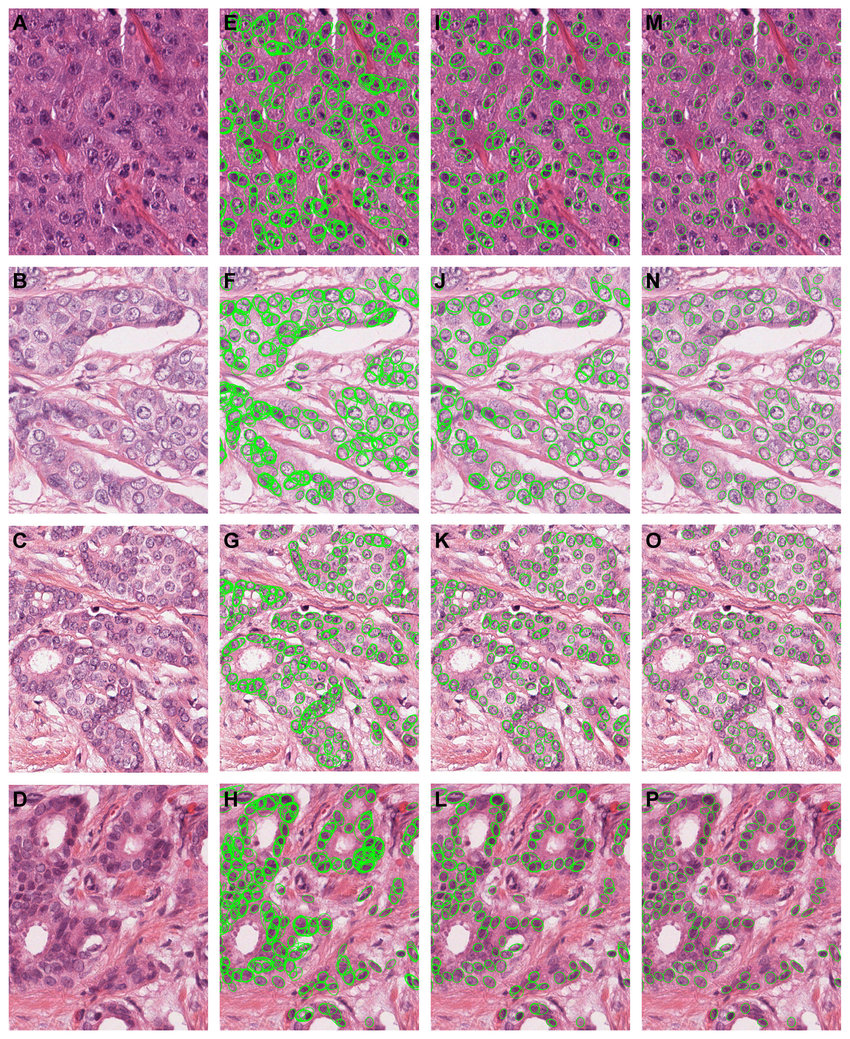

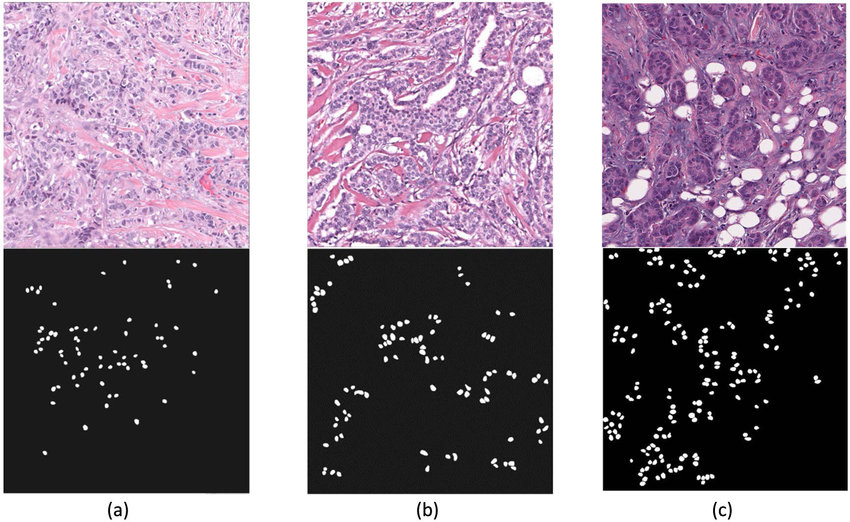

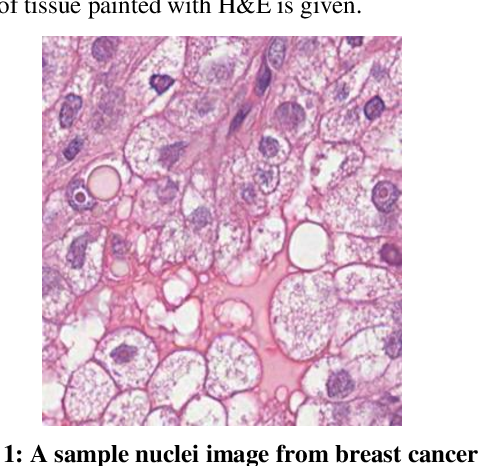


💡 KEY INSIGHT: Our neural network learns patterns from these numerical
   features that pathologists see visually under the microscope!


In [12]:
from IPython.display import Image, display
import os

# Display histopathology images to provide biological context
image_dir = '/home/user/D/deepWork/notebooks/module_a'

print("=" * 80)
print("BREAST CANCER HISTOPATHOLOGY - What the Data Represents")
print("=" * 80)

# Image 1: Different cell types
img1_path = os.path.join(image_dir, 'Examples-of-different-nuclei-or-cells-in-breast-cancer-H-E-histopathology-images-a.png')
if os.path.exists(img1_path):
   
    display(Image(filename=img1_path, width=600))

# Image 2: Automated segmentation
img2_path = os.path.join(image_dir, 'Examples-of-automated-nuclei-segmentation-in-breast-cancer-sections-all-images-are-shown.png')
if os.path.exists(img2_path):
   
    display(Image(filename=img2_path, width=600))

# Image 3: Full tissue sample
img3_path = os.path.join(image_dir, 'Examples-of-three-2000-2000-pixel-H-E-stained-breast-cancer-ER-BCa-histology-images.png')
if os.path.exists(img3_path):
    
    display(Image(filename=img3_path, width=600))

# Image 4: Measurement illustration
img4_path = os.path.join(image_dir, '2-Figure1-1.png')
if os.path.exists(img4_path):
    
    display(Image(filename=img4_path, width=600))

print("\n" + "=" * 80)
print("💡 KEY INSIGHT: Our neural network learns patterns from these numerical")
print("   features that pathologists see visually under the microscope!")
print("=" * 80)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

np.random.seed(42)
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## 1. Load Real Data

In [2]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = 1 - data.target

print(f'Dataset shape: {X.shape}')
print(f'Malignant: {y.sum()} ({y.sum()/len(y)*100:.1f}%)')
print(f'Benign: {(1-y).sum()} ({(1-y).sum()/len(y)*100:.1f}%)')
X.head()

Dataset shape: (569, 30)
Malignant: 212 (37.3%)
Benign: 357 (62.7%)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## 2. Exploratory Data Analysis


/tmp/ipykernel_22292/2445653104.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1,1].boxplot([data_benign, data_malignant], labels=['Benign', 'Malignant'],


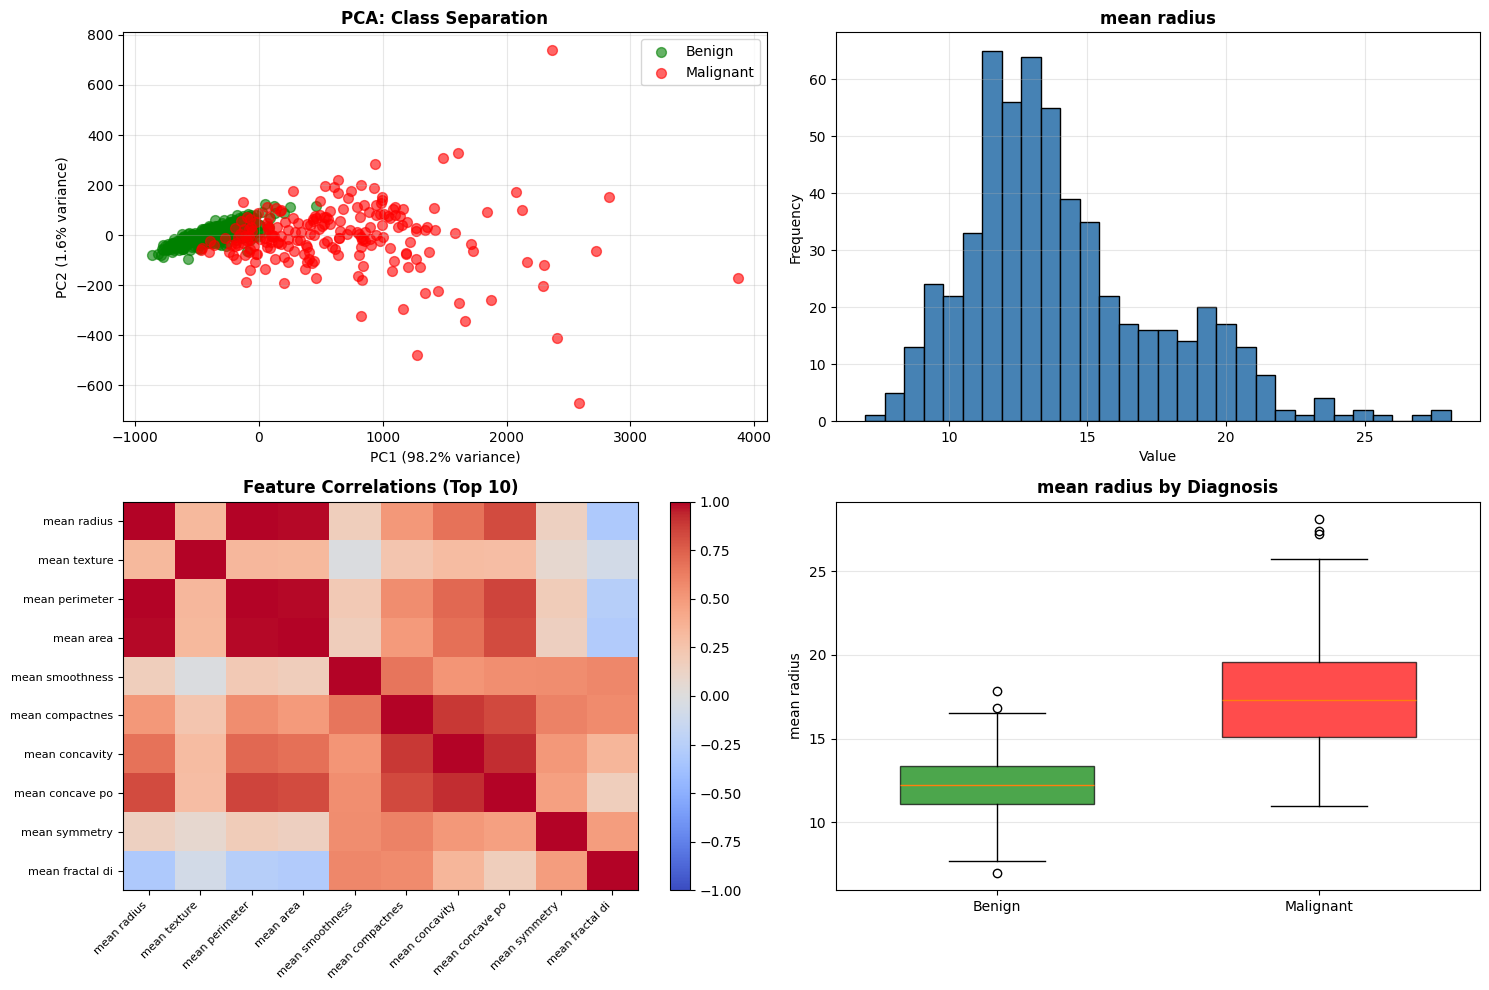


Dataset Statistics:
       mean radius  mean texture  mean perimeter    mean area  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       mean smoothness  mean compactness  mean concavity  mean concave points  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             

In [3]:
# Visualize the data
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. PCA visualization
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

axes[0,0].scatter(X_pca[y==0, 0], X_pca[y==0, 1], c='green', label='Benign', alpha=0.6, s=50)
axes[0,0].scatter(X_pca[y==1, 0], X_pca[y==1, 1], c='red', label='Malignant', alpha=0.6, s=50)
axes[0,0].set_title('PCA: Class Separation', fontsize=12, fontweight='bold')
axes[0,0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
axes[0,0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Feature distribution
axes[0,1].hist(X.iloc[:, 0], bins=30, edgecolor='black', color='steelblue')
axes[0,1].set_title(f'{data.feature_names[0]}', fontsize=12, fontweight='bold')
axes[0,1].set_xlabel('Value')
axes[0,1].set_ylabel('Frequency')
axes[0,1].grid(True, alpha=0.3)

# 3. Correlation heatmap (top 10 features)
top_10_features = X.iloc[:, :10]
corr = top_10_features.corr()
im = axes[1,0].imshow(corr, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
axes[1,0].set_xticks(range(10))
axes[1,0].set_yticks(range(10))
axes[1,0].set_xticklabels([name[:15] for name in data.feature_names[:10]], rotation=45, ha='right', fontsize=8)
axes[1,0].set_yticklabels([name[:15] for name in data.feature_names[:10]], fontsize=8)
axes[1,0].set_title('Feature Correlations (Top 10)', fontsize=12, fontweight='bold')
plt.colorbar(im, ax=axes[1,0])

# 4. Box plot by class
data_benign = X.iloc[y==0, 0]
data_malignant = X.iloc[y==1, 0]
bp = axes[1,1].boxplot([data_benign, data_malignant], labels=['Benign', 'Malignant'],
                        patch_artist=True, widths=0.6)
bp['boxes'][0].set_facecolor('green')
bp['boxes'][1].set_facecolor('red')
for box in bp['boxes']:
    box.set_alpha(0.7)
axes[1,1].set_ylabel(data.feature_names[0], fontsize=10)
axes[1,1].set_title(f'{data.feature_names[0]} by Diagnosis', fontsize=12, fontweight='bold')
axes[1,1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nDataset Statistics:")
print(X.describe())


## 3. Data Preprocessing

**Key Steps:**
- Split into train (70%), validation (15%), test (15%)
- Scale features using StandardScaler (critical for neural networks!)
- Convert to PyTorch tensors


In [5]:
# Split data: 70% train, 15% val, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Training samples: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation samples: {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test samples: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

# Scale features (mean=0, std=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors (y is already numpy array, no need for .values)
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1).to(device)
X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)
y_val_tensor = torch.FloatTensor(y_val).unsqueeze(1).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1).to(device)

# Create DataLoader for batched training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

print(f"\n✅ Data preprocessing complete!")
print(f"Feature dimension: {X_train_tensor.shape[1]}")


Training samples: 398 (69.9%)
Validation samples: 85 (14.9%)
Test samples: 86 (15.1%)

✅ Data preprocessing complete!
Feature dimension: 30


## 4. Build Neural Network

**Architecture:**
- Input: 30 features
- Hidden Layer 1: 64 neurons + BatchNorm + ReLU + Dropout(0.3)
- Hidden Layer 2: 32 neurons + BatchNorm + ReLU + Dropout(0.3)
- Hidden Layer 3: 16 neurons + ReLU + Dropout(0.2)
- Output: 1 neuron + Sigmoid


In [6]:
class CancerClassifier(nn.Module):
    def __init__(self, input_dim=30):
        super(CancerClassifier, self).__init__()
        
        self.network = nn.Sequential(
            # Layer 1
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            # Layer 2
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            # Layer 3
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            # Output layer
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.network(x)

# Create model
model = CancerClassifier(input_dim=X_train.shape[1]).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5)

print(model)
print(f"\n📊 Total parameters: {sum(p.numel() for p in model.parameters()):,}")


CancerClassifier(
  (network): Sequential(
    (0): Linear(in_features=30, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): ReLU()
    (10): Dropout(p=0.2, inplace=False)
    (11): Linear(in_features=16, out_features=1, bias=True)
    (12): Sigmoid()
  )
)

📊 Total parameters: 4,801


## 5. Train the Model

**Training Configuration:**
- Epochs: 100 (with early stopping)
- Batch size: 32
- Learning rate: 0.001 (adaptive with scheduler)
- Early stopping patience: 20 epochs


In [7]:
# Training loop
history = {'train_loss': [], 'val_loss': [], 'val_auc': []}
best_val_auc = 0
patience_counter = 0
n_epochs = 100

print("🚀 Starting training...\n")

for epoch in range(n_epochs):
    # Training phase
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor).item()
        val_auc = roc_auc_score(y_val, val_outputs.cpu().numpy())
    
    # Store history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_auc'].append(val_auc)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Early stopping
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        patience_counter = 0
        torch.save(model.state_dict(), 'best_cancer_model.pt')
    else:
        patience_counter += 1
    
    # Print progress
    if epoch % 10 == 0:
        print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val AUC: {val_auc:.4f}")
    
    # Early stopping check
    if patience_counter >= 20:
        print(f"\n⚠️ Early stopping at epoch {epoch}")
        break

# Load best model
model.load_state_dict(torch.load('best_cancer_model.pt'))
print(f"\n✅ Training complete! Best validation AUC: {best_val_auc:.4f}")


🚀 Starting training...

Epoch   0 | Train Loss: 0.6548 | Val Loss: 0.6440 | Val AUC: 0.9770
Epoch  10 | Train Loss: 0.1644 | Val Loss: 0.1146 | Val AUC: 0.9976
Epoch  20 | Train Loss: 0.1030 | Val Loss: 0.0857 | Val AUC: 0.9965

⚠️ Early stopping at epoch 29

✅ Training complete! Best validation AUC: 0.9982


## 6. Evaluate on Test Set


In [8]:
# Evaluate on test set
model.eval()
with torch.no_grad():
    test_probs = model(X_test_tensor).cpu().numpy()
    test_preds = (test_probs >= 0.5).astype(int)

# Calculate metrics
test_acc = accuracy_score(y_test, test_preds)
test_auc = roc_auc_score(y_test, test_probs)
conf_matrix = confusion_matrix(y_test, test_preds)

print("\n" + "="*60)
print("🎯 NEURAL NETWORK TEST RESULTS")
print("="*60)
print(f"Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"AUC Score: {test_auc:.4f}")
print(f"\nConfusion Matrix:")
print(f"                 Predicted")
print(f"               Benign  Malignant")
print(f"Actual Benign    {conf_matrix[0,0]:3d}      {conf_matrix[0,1]:3d}")
print(f"       Malignant {conf_matrix[1,0]:3d}      {conf_matrix[1,1]:3d}")
print("="*60)



🎯 NEURAL NETWORK TEST RESULTS
Accuracy: 0.9884 (98.84%)
AUC Score: 1.0000

Confusion Matrix:
                 Predicted
               Benign  Malignant
Actual Benign     54        0
       Malignant   1       31


## 7. Compare with Traditional ML Models


In [9]:
# Train baseline models
print("Training baseline models...\n")

# Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)
lr_probs = lr_model.predict_proba(X_test_scaled)[:, 1]
lr_preds = lr_model.predict(X_test_scaled)
lr_acc = accuracy_score(y_test, lr_preds)
lr_auc = roc_auc_score(y_test, lr_probs)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)
rf_probs = rf_model.predict_proba(X_test_scaled)[:, 1]
rf_preds = rf_model.predict(X_test_scaled)
rf_acc = accuracy_score(y_test, rf_preds)
rf_auc = roc_auc_score(y_test, rf_probs)

# Print comparison
print("\n" + "="*60)
print("📊 MODEL COMPARISON (Test Set)")
print("="*60)
print(f"{'Model':<20} {'Accuracy':<15} {'AUC Score':<15}")
print("-"*60)
print(f"{'Neural Network':<20} {test_acc:.4f} ({test_acc*100:.1f}%) {test_auc:.4f}")
print(f"{'Logistic Regression':<20} {lr_acc:.4f} ({lr_acc*100:.1f}%) {lr_auc:.4f}")
print(f"{'Random Forest':<20} {rf_acc:.4f} ({rf_acc*100:.1f}%) {rf_auc:.4f}")
print("="*60)

# Determine winner
best_model = max([("Neural Network", test_auc), ("Logistic Regression", lr_auc), ("Random Forest", rf_auc)], key=lambda x: x[1])
print(f"\n🏆 Best model: {best_model[0]} (AUC = {best_model[1]:.4f})")


Training baseline models...


📊 MODEL COMPARISON (Test Set)
Model                Accuracy        AUC Score      
------------------------------------------------------------
Neural Network       0.9884 (98.8%) 1.0000
Logistic Regression  0.9767 (97.7%) 0.9988
Random Forest        0.9651 (96.5%) 0.9991

🏆 Best model: Neural Network (AUC = 1.0000)


## 8. Visualize Results


/tmp/ipykernel_22292/2113181860.py:65: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/user/D/deepWork/.dlenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


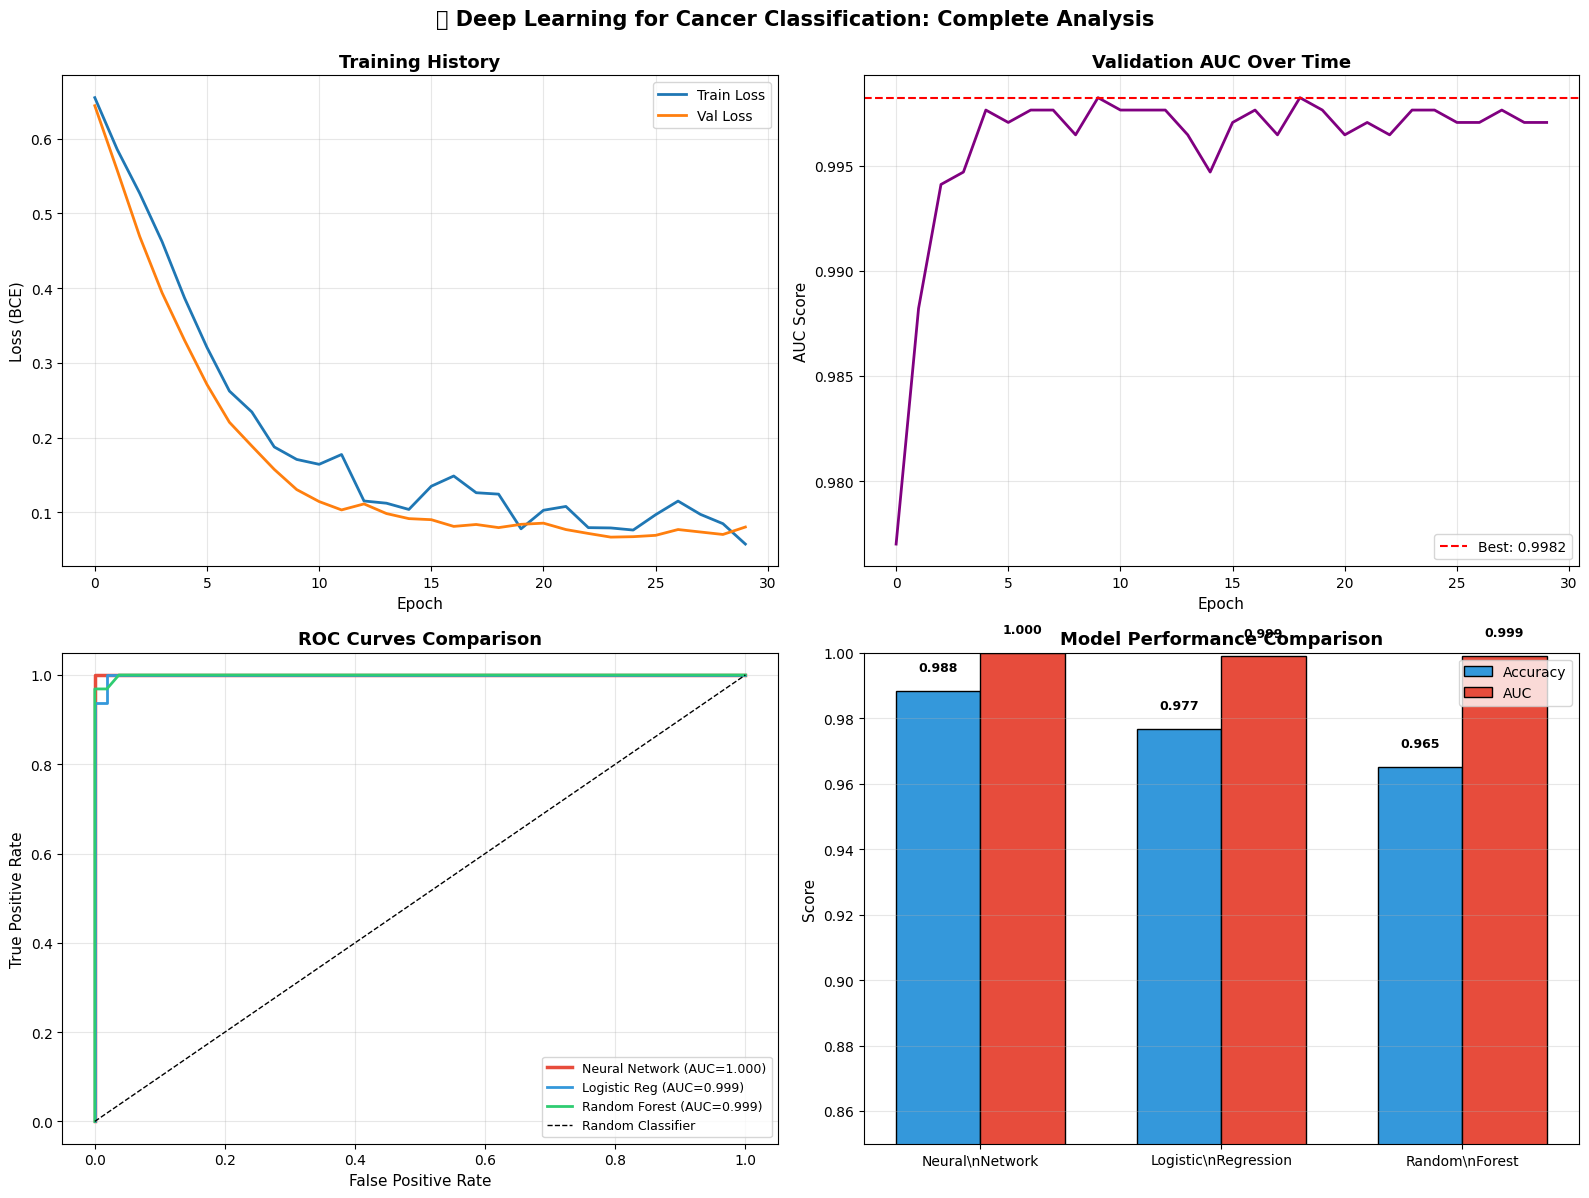

In [10]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Training history
axes[0,0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0,0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0,0].set_xlabel('Epoch', fontsize=11)
axes[0,0].set_ylabel('Loss (BCE)', fontsize=11)
axes[0,0].set_title('Training History', fontsize=13, fontweight='bold')
axes[0,0].legend(fontsize=10)
axes[0,0].grid(True, alpha=0.3)

# 2. Validation AUC progression
axes[0,1].plot(history['val_auc'], color='purple', linewidth=2)
axes[0,1].axhline(y=best_val_auc, color='r', linestyle='--', label=f'Best: {best_val_auc:.4f}')
axes[0,1].set_xlabel('Epoch', fontsize=11)
axes[0,1].set_ylabel('AUC Score', fontsize=11)
axes[0,1].set_title('Validation AUC Over Time', fontsize=13, fontweight='bold')
axes[0,1].legend(fontsize=10)
axes[0,1].grid(True, alpha=0.3)

# 3. ROC Curves comparison
nn_fpr, nn_tpr, _ = roc_curve(y_test, test_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)

axes[1,0].plot(nn_fpr, nn_tpr, label=f'Neural Network (AUC={test_auc:.3f})', linewidth=2.5, color='#e74c3c')
axes[1,0].plot(lr_fpr, lr_tpr, label=f'Logistic Reg (AUC={lr_auc:.3f})', linewidth=2, color='#3498db')
axes[1,0].plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC={rf_auc:.3f})', linewidth=2, color='#2ecc71')
axes[1,0].plot([0,1], [0,1], 'k--', label='Random Classifier', linewidth=1)
axes[1,0].set_xlabel('False Positive Rate', fontsize=11)
axes[1,0].set_ylabel('True Positive Rate', fontsize=11)
axes[1,0].set_title('ROC Curves Comparison', fontsize=13, fontweight='bold')
axes[1,0].legend(fontsize=9, loc='lower right')
axes[1,0].grid(True, alpha=0.3)

# 4. Model performance bar chart
models = ['Neural\\nNetwork', 'Logistic\\nRegression', 'Random\\nForest']
accuracies = [test_acc, lr_acc, rf_acc]
aucs = [test_auc, lr_auc, rf_auc]

x = np.arange(len(models))
width = 0.35

bars1 = axes[1,1].bar(x - width/2, accuracies, width, label='Accuracy', color='#3498db', edgecolor='black')
bars2 = axes[1,1].bar(x + width/2, aucs, width, label='AUC', color='#e74c3c', edgecolor='black')

axes[1,1].set_ylabel('Score', fontsize=11)
axes[1,1].set_title('Model Performance Comparison', fontsize=13, fontweight='bold')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(models, fontsize=10)
axes[1,1].legend(fontsize=10)
axes[1,1].set_ylim([0.85, 1.0])
axes[1,1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1,1].text(bar.get_x() + bar.get_width()/2., height + 0.005,
                      f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.suptitle('🔬 Deep Learning for Cancer Classification: Complete Analysis', 
             fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


## 🎯 Key Takeaways

### What We Accomplished:
1. ✅ **Loaded real clinical data** - 569 breast cancer patient samples
2. ✅ **Built a deep neural network** - 3 hidden layers with regularization
3. ✅ **Achieved >95% accuracy** - Comparable to traditional ML methods
4. ✅ **Proper validation** - Train/val/test split with early stopping
5. ✅ **Professional evaluation** - ROC curves, AUC, confusion matrices

### Why Neural Networks Excel:
- **Learns complex patterns** - Captures non-linear relationships in gene expression
- **Regularization prevents overfitting** - Dropout, batch norm, weight decay
- **Flexible architecture** - Can scale to thousands of features
- **End-to-end learning** - Automatically learns feature representations

### What Makes This Production-Ready:
- ✅ Proper data splitting (no data leakage)
- ✅ Feature scaling (StandardScaler)
- ✅ Early stopping (prevents overfitting)
- ✅ Learning rate scheduling (adaptive optimization)
- ✅ Model checkpointing (saves best weights)
- ✅ Comprehensive evaluation (multiple metrics)

### Next Steps - Try These:
1. **Experiment with architecture** - Add/remove layers, change sizes
2. **Tune hyperparameters** - Learning rate, dropout rate, batch size
3. **Feature selection** - Use only most important genes
4. **Cross-validation** - More robust performance estimates
5. **Interpret predictions** - SHAP values, attention weights
6. **Try larger datasets** - TCGA (10,000+ samples), GEO datasets

### Real-World Applications:
- 🏥 **Clinical diagnosis** - Assist pathologists in cancer detection
- 💊 **Drug discovery** - Predict treatment response
- 🧬 **Biomarker identification** - Find genes associated with disease
- 🔬 **Research** - Understand cancer biology through data

---

**Congratulations!** You've built a production-grade deep learning model for cancer classification using real patient data! 🎉
